# data_preprocess.ipynb

This jupyter notebook demonstrates how to preprocess the dataset by normalizing voxel values to have 0 mean and unit standard deviation

In [2]:
%pip install nibabel

     |████████████████████████████████| 3.3MB 2.6MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import sys

import utils

## Preprocess

In [14]:
directories = [
    '../MICCAI_BraTS_2018_Data_Training/HGG', #210 patients
    '../MICCAI_BraTS_2018_Data_Training/LGG' #75 patients
]

output_directory = '../preprocessed'

split = 0.8 #fraction for training set
    
def normalize(input_data):
    non_zero_mask = np.where(input_data > 0)
    masked_input_data = input_data[non_zero_mask]
    masked_mean = masked_input_data.mean()
    masked_std = masked_input_data.std()
    normalized_data = np.zeros(input_data.shape)
    normalized_data[non_zero_mask] = (input_data[non_zero_mask] - masked_mean) / (masked_std + 1e-12)
    return normalized_data, (normalized_data[non_zero_mask].mean(), normalized_data[non_zero_mask].std())

patients = []

for dir in directories:
    for patient in os.listdir(dir):
        if not patient.startswith('.'):
            patients.append({ 'patient': patient, 'path': os.path.join(dir, patient)})

print(len(patients))

#shuffle and split into train and validation sets
np.random.shuffle(patients)
split_index = int(split*len(patients))
training_set = patients[:split_index]
validation_set = patients[split_index:]

print('Training set: {} patients'.format(len(training_set)))
print('Validation set: {} patients'.format(len(validation_set)))

for item in training_set:
    for root, dirs, files in os.walk(item['path']):
        for file in files:
            if file.endswith('.nii.gz'):

                full_file_path = os.path.join(root, file)

                output_path = os.path.join(
                    output_directory,
                    'train',
                    item['patient'],
                    file.replace('.nii.gz', '.nii')
                )

                # Create output directory if not yet exists
                directory = os.path.dirname(output_path)
                if not os.path.exists(directory):
                    os.makedirs(directory)

                # Read NifTI file
                data, affine = utils.read_nii(full_file_path)

                # Normalize
                if not file.endswith('seg.nii.gz'):
                    data, stats = normalize(data)

                # Transpose
                data = data.transpose(2, 0, 1)

                # Save to file
                utils.save_nii(data, output_path)


285
Training set: 228 patients
Validation set: 57 patients


## Visualize

788.0 9.649369025355409


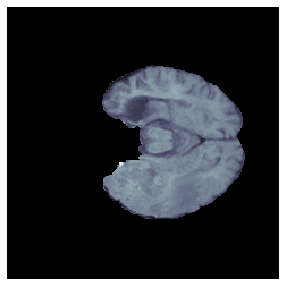

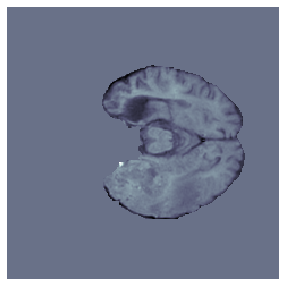

In [71]:
#Visualize data
def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img, cmap=plt.cm.bone)
    #plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
raw_file = '../MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_471_1/Brats18_TCIA02_471_1_t1.nii.gz'
normalized_file = '../preprocessed/train/Brats18_TCIA02_471_1/Brats18_TCIA02_471_1_t1.nii'
raw_data = read_nii(raw_file)
normalized_data = read_nii(normalized_file)

frame_id = 50

plt.figure(figsize=(15,5))
imshow_no_ax(raw_data[:,:,frame_id], normalize=False)

plt.figure(figsize=(15,5))
imshow_no_ax(normalized_data[frame_id,:,:], normalize=False)

print(raw_data.max(), normalized_data.max())